In [1]:
#Import modules

import os
import numpy as np
import pandas as pd
import matplotlib as plt
from pathlib2 import Path
from PIL import Image
import torch
import math
import torch.nn as nn
from torchvision.transforms import transforms
from matplotlib import pyplot
import pandas as pd
from fastai.callbacks import *
from fastai.vision import *
from PIL import Image
from fastai.widgets import *



In [34]:
#Define data paths

ESRG = 1 #Control Resolution
DATA_PATH = Path(os.getcwd()+"/data")
PATH = DATA_PATH/"kaggle"


if ESRG == 1:
    TRAIN_PATH = PATH/"upsampled_images"
    TEST_PATH = PATH/"upsampled_test"
    RES = 112
else:
    TRAIN_PATH = PATH/"train_images"
    TEST_PATH = PATH/"test_images"
    RES = 112



In [12]:
#Define dataloader
sketch_data = ImageDataBunch.from_folder(TRAIN_PATH, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=RES, num_workers=1).normalize(mnist_stats)

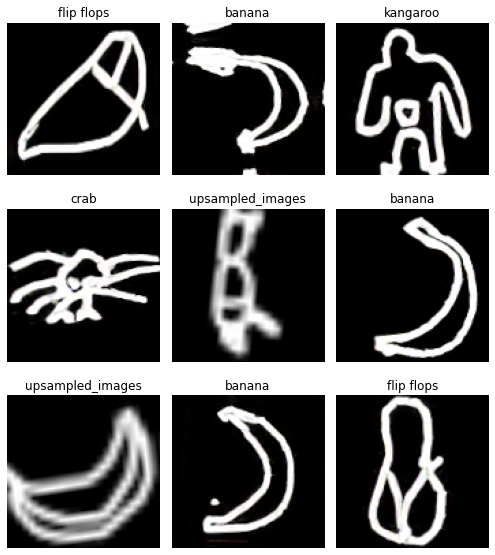

In [13]:
#Glimpse data
sketch_data.show_batch(rows=3, figsize=(7,8))

In [5]:
#Define model
learn = cnn_learner(sketch_data, models.resnet34, metrics=error_rate,
                                       callback_fns=[partial(EarlyStoppingCallback, 
                                          monitor='error_rate', 
                                          mode = 'min',
                                          min_delta=0.00075, 
                                          patience=4),
                                        partial(SaveModelCallback,
                                          every='epoch', 
                                          monitor='error_rate',
                                          mode = 'min',
                                          name='model')
                                 ])

In [6]:
#Train model head
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.064578,0.508739,0.143333,00:36
1,0.700316,0.460033,0.129167,00:19
2,0.570644,0.366970,0.110833,00:20
3,0.446057,0.318179,0.097500,00:19
4,0.395169,0.319432,0.099167,00:19


In [7]:
#load selected model
#learn.load('model_3')

In [8]:
#Unfreeze model body weights
learn.freeze()
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


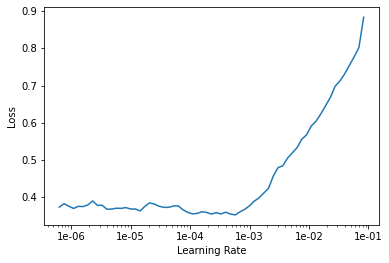

In [9]:
#Use LR finder and plot results
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time
0,0.386264,0.307192,0.088333,00:19
1,0.344449,0.284926,0.092500,00:19
2,0.310019,0.270631,0.074167,00:19
3,0.262104,0.247576,0.071667,00:19
4,0.225659,0.259511,0.072500,00:19
5,0.189589,0.233664,0.065833,00:19
6,0.157272,0.240756,0.061667,00:19
7,0.132564,0.244590,0.066667,00:19
8,0.110641,0.247511,0.063333,00:19
9,0.107674,0.250138,0.060833,00:19


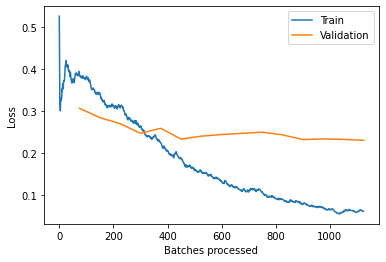

In [10]:
#Train on rest of model
learn.fit_one_cycle(15, max_lr=slice(1e-4,1e-5))
learn.recorder.plot_losses()

In [17]:
learn.load('model_3')

Learner(data=ImageDataBunch;

Train: LabelList (4782 items)
x: ImageList
Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114)
y: CategoryList
flip flops,flip flops,flip flops,flip flops,flip flops
Path: /projects/qg35/jlgao2/FYP-Sandbox/data/kaggle/upsampled_images;

Valid: LabelList (1195 items)
x: ImageList
Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114)
y: CategoryList
flip flops,cactus,boomerang,banana,cactus
Path: /projects/qg35/jlgao2/FYP-Sandbox/data/kaggle/upsampled_images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, k

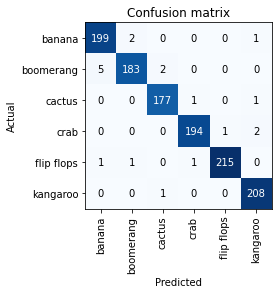

In [18]:
#Plot Confusion Matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

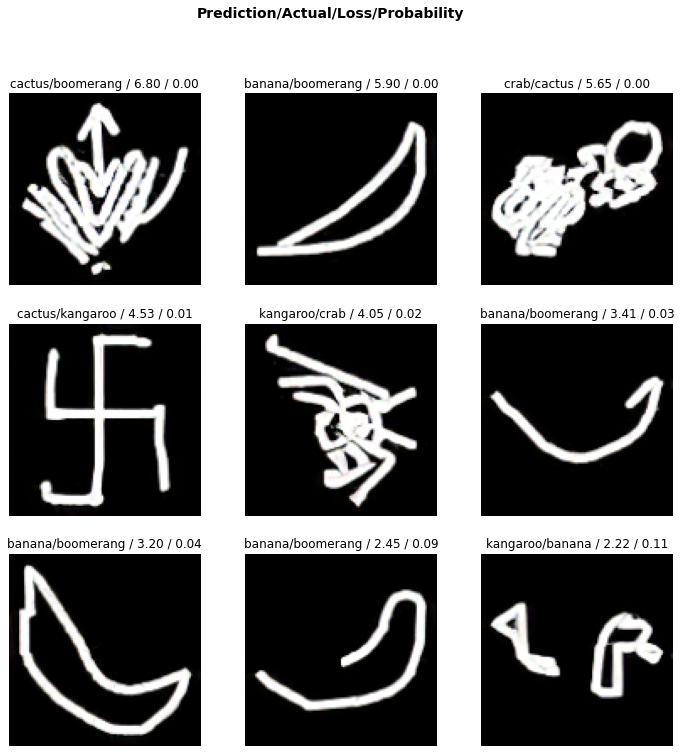

In [19]:
interp.plot_top_losses(9)

Export Results using current model

In [20]:
defaults.device = torch.device('cpu')

pred_class = []
pred_idx = []
outputs = []

for i in range(1200):
    idx = i+1
    img = open_image(str(TEST_PATH)+"/"+str(idx)+".png")
    a,b,c = learn.predict(img)
    pred_class.append(a)
    pred_idx.append(b)
    outputs.append(c)

df = pd.DataFrame(data={"id": range(1,1201,1), "Category": pred_class})
df.to_csv("./result_pd.csv", sep=',',index=False)

defaults.device = torch.device('cuda')


RuntimeError: Expected one of cpu, cuda, mkldnn, opengl, opencl, ideep, hip, msnpu device type at start of device string: gpu

Appendix: Dataset Cleaning Widget

In [ ]:
db = (ImageList.from_folder(TRAIN_PATH)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=114)
                   .databunch()
     )

In [ ]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [ ]:
something, ds, idxs = DatasetFormatter().from_most_unsure(db, learn_cln)

In [ ]:
# Don't run this in google colab or any other instances running jupyter lab.
# If you do run this on Jupyter Lab, you need to restart your runtime and
# runtime state including all local variables will be lost.
ImageCleaner(ds, idxs, TRAIN_PATH)

Appendix: Data Processing Code

In [19]:
sketch_df = pd.read_csv(PATH/'sketches_train.csv')
test_df = pd.read_csv(PATH/'sketches_test.csv')

In [20]:
sketch_x = sketch_df.iloc[:,1:785]
test_x = test_df.iloc[:,1:785]
test_x.head

<bound method NDFrame.head of       V1  V2  V3  V4  V5  V6  V7  V8  V9  V10  ...  V775  V776  V777  V778  \
0      0   0   0   0   0   0   0   0   0    0  ...     0     0     0     0   
1      0   0   0   0   0   0   0   0   0    0  ...     0     0     0     0   
2      0   0   0   0   0   0   0   0   0    0  ...     0     0     0     0   
3      0   0   0   0   0   0   0   0   0    0  ...     0     0     0     0   
4      0   0   0   0   0   0   0   0   0    0  ...     0     0     0     0   
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...   ...   ...   ...   ...   
1195   0   0   0   0   0   0   0   0   0    0  ...     0     0     0     0   
1196   0   0   0   0   0   0   0   0   0    0  ...     0     0     0     0   
1197   0   0   0   0   0   0   0   0   0    0  ...     0     0     0     0   
1198   0   0   0   0   0   0   0   0   0    0  ...     0     0     0     0   
1199   0   0   0   0   0   0   0   0   0    0  ...     0     0     0     0   

      V779  V780  V781  V782  V78

In [21]:
sketch_y = sketch_df.iloc[:,785:786]
sketch_y.head

<bound method NDFrame.head of            word
0     boomerang
1     boomerang
2     boomerang
3     boomerang
4     boomerang
...         ...
5995     banana
5996     banana
5997     banana
5998     banana
5999     banana

[6000 rows x 1 columns]>

In [22]:
(sketch_x.to_numpy()[5]).shape

(784,)

In [27]:
#make images from array
i = 0
for row in sketch_x.to_numpy(): #get numpy array from pandas df 
    arr = row 
    i += 1
    sqr = arr.reshape(28,28).astype(np.uint8)
    img = Image.fromarray(sqr)
    img = img.resize((112,112))
    img.save(str(TRAIN_PATH)+"/"+str(i)+".png", "PNG")

In [28]:
#organise images into class folders

shapeIDs = list(sketch_y['word'].unique())

#Run Once to make img
for s in shapeIDs:
    if not os.path.isdir(str(TRAIN_PATH)+'/'+s):
        os.makedirs(str(TRAIN_PATH)+'/'+s)

for idx in sketch_y.index:
    image = str(idx+1)+'.png'
    folder = sketch_y.loc[idx, 'word']
    old = 'C:/Users/georg/.fyp/data/kaggle/'/TRAIN_PATH/'{}'.format(image)
    new = 'C:/Users/georg/.fyp/data/kaggle/'/TRAIN_PATH/'{}/{}'.format(folder, image)
    try:
        os.rename(old, new)
    except:
        print('{} - {}'.format(image,folder))

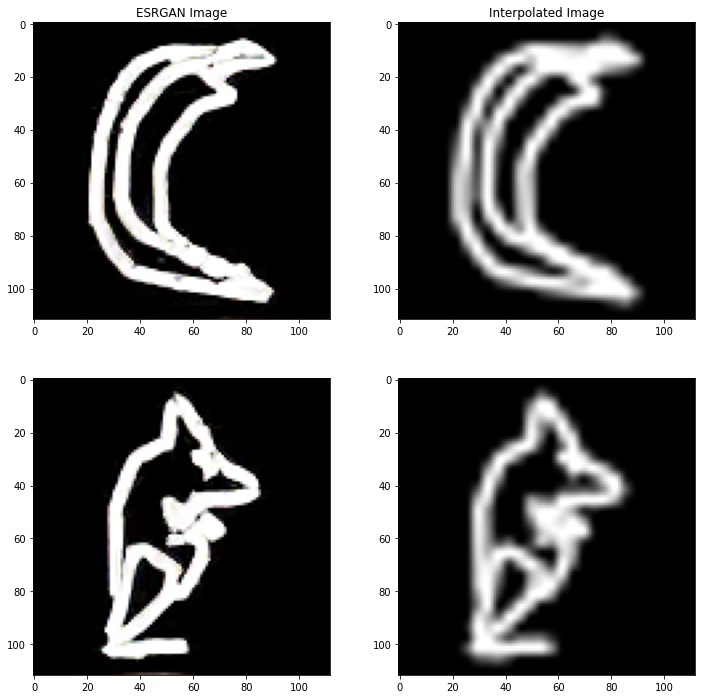

In [41]:
I_TRAIN_PATH = PATH/"train_images"

plt.figure(figsize = (12, 12))
plt.subplot(2,2,1)
plt.title("ESRGAN Image")
plt.imshow(Image.open(TRAIN_PATH/'banana'/'5001.png'))
plt.subplot(2,2,3)
plt.imshow(Image.open(TRAIN_PATH/'kangaroo'/'1001.png'))


plt.subplot(2,2,2)
plt.title("Interpolated Image")
plt.imshow(Image.open(I_TRAIN_PATH/'banana'/'5001.png'), cmap='gray')
plt.subplot(2,2,4)
plt.imshow(Image.open(I_TRAIN_PATH/'kangaroo'/'1001.png'), cmap='gray')